In [34]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./libs')

import matplotlib.pyplot as plt
import colorcet as cc
import numpy as np
import pandas as pd
import h5py
from ipywidgets import interact, widgets
import ats_vis as atsvis
import ats_xdmf as ats_xdmf
import pyvista as pv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualize exodus2 mesh

In [35]:
domain_mesh = atsvis.load_mesh_exodus('../data/synthetic_catchment.exo', z_scale=20)
atsvis.plot_mesh(domain_mesh, show_scalar_bar=True, set_background=False,
                 show_toplayer=True, window_size=[800, 400])

Widget(value='<iframe src="http://localhost:59542/index.html?ui=P_0x3068a3110_3&reconnect=auto" class="pyvista…

## Load ATS output files

In [36]:
# Load mesh polygons and data
data_directory = '../2-transport/results/'
domain = h5py.File(f'{data_directory}/ats_vis_data.h5', 'r')
domain_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_mesh.h5')
surface = h5py.File(f'{data_directory}/ats_vis_surface_data.h5', 'r')
surface_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_surface_mesh.h5')

In [37]:
# loading domain mesh file
vis_domain = ats_xdmf.VisFile(data_directory, time_unit='hr')
vis_domain.loadMesh()

# loading surface mesh file
vis_surface = ats_xdmf.VisFile(data_directory, domain='surface', time_unit='hr')
vis_surface.loadMesh()

# getting time and number of steps
time = vis_domain.times
cycles = vis_domain.cycles
num_steps = len(cycles)
num_surface_elements = np.shape(vis_surface.centroids)[0]
num_layers = int(np.shape(vis_domain.centroids)[0] / num_surface_elements)
print(f'Number of times: {num_steps}')
print(f'Number of surface elements: {num_surface_elements}')
print(f'Number of layers: {num_layers}')

Number of times: 49
Number of surface elements: 1521
Number of layers: 7


## Plot surface domain

In [38]:
vars_hydro = ['pres_elev', 'ponded_depth']
interact(
    lambda step: atsvis.plot_surface(
        vars_hydro, surface_polygons, vis_surface, step, time,
        vmin=[None, 0],
        vmax=[None, 1],
        units=['[m]', '[m]'],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), Output()), _dom…

<function __main__.<lambda>(step)>

In [39]:
vars_surface = ['total_component_concentration.Tracer1', 'total_component_quantity.Tracer1']
interact(
    lambda step: atsvis.plot_surface(
        vars_surface, surface_polygons, vis_surface, step, time, showbox=True,
        vmin=[1e-10, 1e-6],
        vmax=[1e0, 1e2],
        logscales=[True, True],
        units=['mol/molH2O', 'mol'],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), Output()), _dom…

<function __main__.<lambda>(step)>

## Plot subsurface domain

In [40]:
vars_domain = ['total_component_concentration.Tracer1', 'total_component_quantity.Tracer1']
interact(
    lambda step, layer: atsvis.plot_domain(
        vars_domain, surface_polygons, vis_domain, num_surface_elements, step, time, layer,
        vmin=[1e-10, 1e-4],
        vmax=[1e0, 1e4],
        logscale=[True, True],
        units=['mol/molH2O', 'mol'],
        cmap=[cc.cm.CET_L17, cc.cm.CET_L17],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False),
    layer=widgets.IntSlider(min=0, max=num_layers-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), IntSlider(value…

<function __main__.<lambda>(step, layer)>

## Plot Observations

#### Read the observations file

In [41]:
fname = f'{data_directory}/observations.csv'
num_lines = atsvis.get_skip_number(fname)

observations = pd.read_csv(fname,skiprows=num_lines,sep=",")
time_obs = observations['time [h]']
surface_flux_outlet = observations['surface-flux-outlet']
surface_concentration_outlet = observations['surface-total_component_concentration-outlet']
surface_quantity_outlet = observations['surface-total_component_quantity-outlet Tracer1']

#### Plotting

In [42]:
# Read rainfall data from xml file
xml_file = '../2-transport/solution_transport.xml'
rainfall = atsvis.get_rainfall_from_xml(xml_file, time_obs, sfactor=1000*3600)
tracer_source = atsvis.get_tracer_source_from_xml(xml_file, time_obs, sfactor=3600)

In [43]:
# Surface fluxes
surface_flux_data = [surface_flux_outlet]
surface_flux_labels = ['Outlet Face']

# Surface tracer concentration
surface_tracer_concentration_data = [surface_concentration_outlet]
surface_tracer_concentration_labels = ['Outlet Cell']

# Surface tracer concentration
surface_tracer_quantity_data = [surface_quantity_outlet]
surface_tracer_quantity_labels = ['Outlet Cell']


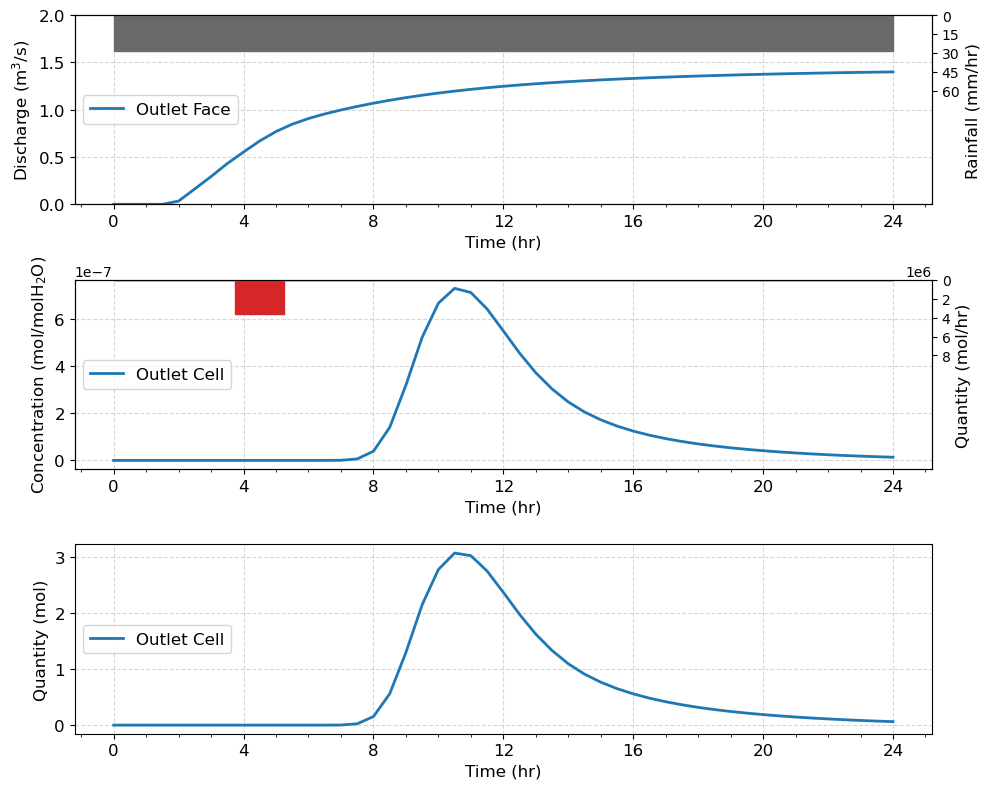

In [44]:
liq_mol_den = 55500  # mol/m^3
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plot rainfall and water flux time series
atsvis.plot_field_timeseries(
    time_obs, surface_flux_data, surface_flux_labels, sfactor=1./liq_mol_den, ylim=[0, 2],
    ylabel='Discharge (m$^3$/s)', ax=ax[0]
)
atsvis.plot_sources(time_obs, rainfall, 'Rainfall', ylabel='Rainfall (mm/hr)', ax=ax[0])

# Plot concentration time series
atsvis.plot_field_timeseries(
    time_obs, surface_tracer_concentration_data, surface_tracer_concentration_labels,
    ylabel='Concentration (mol/molH$_2$O)', ax=ax[1]
)
atsvis.plot_sources(time_obs, tracer_source, ylabel='Quantity (mol/hr)', color='tab:red', ax=ax[1])

# Plot quantity time series
atsvis.plot_field_timeseries(
    time_obs, surface_tracer_quantity_data, surface_tracer_quantity_labels, ylabel='Quantity (mol)', ax=ax[2]
)
plt.tight_layout()